# SMART LIVE CAMERA NOTEBOOK

## Necessary modules

In [1]:
# Import Modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Generic functions

### Data Preprocessing Functions

In [6]:
last_percent_reported = None
num_classes = 10

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(URL + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def maybe_extract(filename, force=False):
  """Extract a file (tar). If force=True, override the current files and folders"""
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

### Eval Functions

In [3]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

## 2. STEP TWO: SINGLE DIGIT SVHN DATA

### Downloading data

In [8]:
URL = 'http://ufldl.stanford.edu/housenumbers/'
TRAIN_FILENAME= 'train_32x32.mat'
TEST_FILENAME = 'test_32x32.mat'
EXTRA_FILENAME = 'extra_32x32.mat'

train_filename = maybe_download(TRAIN_FILENAME, 182040794)
test_filename = maybe_download(TEST_FILENAME, 64275384)
# extra_filename = maybe_download(EXTRA_FILENAME, 100) 

Found and verified train_32x32.mat
Found and verified test_32x32.mat


### Extracting data

In [84]:
IMAGE_SIZE = 32
PIXEL_DEPTH = 255
NUM_CHANNELS = 3
VALIDATION_SIZE = 8000

def extract_data(filename):
  """Extract the images into a 3D tensor [image index, y, x].
  Using scipy.io.loadmat 
  """
  print('Extracting', filename)
  data_matfile = loadmat(filename)
  data = data_matfile['X']
  data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # RGV ENCO
  data = data.transpose(3,0,1,2).astype(np.float32)
  labels = data_matfile['y']
  labels = labels.reshape(labels.shape[0],).astype(np.float32)
  return data, labels

train_dataset, train_labels = extract_data('train_32x32.mat')
test_dataset, test_labels = extract_data('test_32x32.mat')
valid_dataset = test_dataset[:VALIDATION_SIZE, ...]
valid_labels = test_labels[:VALIDATION_SIZE]
test_dataset = test_dataset[VALIDATION_SIZE:, ...]
test_labels = test_labels[VALIDATION_SIZE:]
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Extracting train_32x32.mat
Extracting test_32x32.mat
Training set (73257, 32, 32, 3) (73257,)
Validation set (8000, 32, 32, 3) (8000,)
Test set (18032, 32, 32, 3) (18032,)


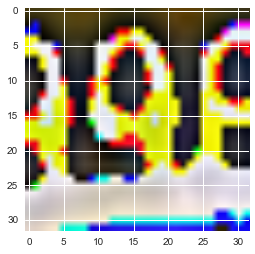

9.0


In [87]:
rd = random.randint(0, len(train_dataset))
plt.imshow(train_dataset[rd,:,:,:])
plt.show()

print(train_labels[rd])

### Simple Logistic Regression

In [38]:
# Defining Params
IMAGE_SIZE = 32
NUM_CHANNELS = 3
NUM_LABELS = 10
BATCH_SIZE = 128

# Defining the Graph
graph = tf.Graph()

with graph.as_default():
  # Input init and constant init. According to the theory 
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE * IMAGE_SIZE)) 
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE)) 
  tf_valid_dataset = tf.constant(valid_dataset) 
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE * IMAGE_SIZE, NUM_LABELS])) # mean0,low std dev, random values
  biases = tf.Variable(tf.zeros([NUM_LABELS])) # zeros
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases # logistic regression
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss) # GD Optimizer
  
  # Predictions for the training, validation, and test data. (Probabilities)
  train_prediction = tf.nn.softmax(logits) 
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases) 
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
  
# Defining hyper-parameters
NUM_STEPS = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print('Validation error: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

ValueError: Shape (8000, 32, 32, 3) must have rank 2

### 2-Layers NN

In [6]:
# Defining Params
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10
BATCH_SIZE = 128
HIDDEN_NODES = 1024

# Defining the Graph
graph = tf.Graph()

with graph.as_default():
  # Input init and constant init. According to the theory 
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE * IMAGE_SIZE)) 
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE)) 
  tf_valid_dataset = tf.constant(valid_dataset) 
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  w1 = tf.Variable(tf.truncated_normal([IMAGE_SIZE * IMAGE_SIZE, HIDDEN_NODES])) 
  b1 = tf.Variable(tf.zeros([HIDDEN_NODES])) 
  w2 = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS])) 
  b2 = tf.Variable(tf.zeros([NUM_LABELS])) 
  
  def twoNN(X):
      return tf.matmul(tf.nn.relu(tf.matmul(X, w1) + b1), w2) + b2
  
  # Training computation.
  logits = twoNN(tf_train_dataset) 
  
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss) # GD Optimizer
  
  # Predictions 
  train_prediction = tf.nn.softmax(logits) 
  valid_prediction = tf.nn.softmax(twoNN(tf_valid_dataset))
  test_prediction = tf.nn.softmax(twoNN(tf_test_dataset))
  
# Defining hyper-parameters
NUM_STEPS = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print('Validation error: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Minibatch loss at step 0: 222.184418
Minibatch accuracy: 13.3%
Validation error: 24.8%
Minibatch loss at step 500: 0.702501
Minibatch accuracy: 93.8%
Validation error: 93.8%
Minibatch loss at step 1000: 0.077048
Minibatch accuracy: 96.9%
Validation error: 94.5%
Minibatch loss at step 1500: 0.099483
Minibatch accuracy: 97.7%
Validation error: 94.5%
Minibatch loss at step 2000: 0.132538
Minibatch accuracy: 96.1%
Validation error: 94.9%
Minibatch loss at step 2500: 0.016459
Minibatch accuracy: 99.2%
Validation error: 94.8%
Minibatch loss at step 3000: 0.000625
Minibatch accuracy: 100.0%
Validation error: 94.9%
Test accuracy: 94.8%


### CNN LeNet-5-like convolutional

In [89]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
NUM_LABELS = 10

In [90]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 32
DEPTH_2 = 64
HIDDEN_NODES = 256

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 16
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))

  # Fully connected depth 256
  fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * DEPTH_2, HIDDEN_NODES],
                                                   stddev=0.1))
  fc1_biases = tf.Variable(tf.constant(1.0, shape=[HIDDEN_NODES]))
  
  fc2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    # 2D Conv Layer
    conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # 2D Conv + ReLU + MaxPooling
    conv = tf.nn.conv2d(pool, conv2_weights, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        
    # Fully connected  
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    return tf.matmul(hidden, fc2_weights) + fc2_biases  
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  
NUM_STEPS = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 12.827404
Minibatch accuracy: 23.4%
Validation accuracy: 11.1%
Minibatch loss at step 500: 10.199642
Minibatch accuracy: 25.0%
Validation accuracy: 10.0%
Minibatch loss at step 1000: 43.704811
Minibatch accuracy: 10.9%


KeyboardInterrupt: 